# The Linear VAE

### Note:
- Please use `pip install -r requirements.txt` to configure the environment.
- This code references the existing implementation: [Google Colab Notebook](https://colab.research.google.com/github/google-research/google-research/blob/master/linear_vae/DontBlameTheELBO.ipynb)


For preliminaries about pPCA and VAE, please obtain it from the report. Here, we only give the eact ELBO computation as follows:

The ELBO is made up of two components, the prior KL divergence (i), $KL(q(\mathbf{z}|\mathbf{x})||p(\mathbf{z}))$ and the reconstruction loss (ii), $\mathbb{E}_{q(\mathbf{z}|\mathbf{x})}[\log p(\mathbf{x}|\mathbf{z})]$.

Because everything is Gaussian, we can compute these terms in closed-form.

(i): $KL(q(\mathbf{z}|\mathbf{x})||p(\mathbf{z})) = 0.5(tr(\mathbf{D}) -\log\det(\mathbf{D}) + (\mathbf{x}-\mathbf{\mu})\mathbf{V}^T\mathbf{V}(\mathbf{x} - \mathbf{\mu}) - q)$

(ii): $\mathbb{E}_{q(\mathbf{z}|\mathbf{x})}\left[ \log p(\mathbf{x}|\mathbf{z}) \right] = \frac{1}{2\sigma^2} [ -tr(\mathbf{W}\mathbf{D}\mathbf{W}^T) - (\mathbf{x} - \mathbf{\mu})^T\mathbf{V}^T\mathbf{W}^T\mathbf{W}\mathbf{V}(\mathbf{x}-\mathbf{\mu}) + 2(\mathbf{x} - \mathbf{\mu})^T\mathbf{W}\mathbf{V}(\mathbf{x}-\mathbf{\mu}) - (\mathbf{x} - \mathbf{\mu})^T(\mathbf{x} - \mathbf{\mu})] - \frac{d}{2}\log 2\pi\sigma^2$

Thus, we can train the linear VAE using exact gradients to validate the theoretical results presented in our paper.

In [1]:
import tensorflow as tf
from tensorflow.data import Dataset
import tensorflow_datasets as tfds

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

_LOG_2PI = np.log(2 * np.pi)

In [2]:
def load_mnist_data(take):
  '''Load a subset of the MNIST dataset, repeated.

  Args:
    take: The amount of training data to take.
  
  Returns:
    A shuffled subset of the MNIST training dataset.
  '''
  mnist_builder = tfds.builder("mnist")
  mnist_info = mnist_builder.info
  mnist_builder.download_and_prepare()
  datasets = mnist_builder.as_dataset()
  train_dataset = datasets['train']
  train_dataset = train_dataset.take(take).map(
      lambda x : tf.reshape(tf.cast(x['image'], tf.float32) / 255.0, [-1]))
  return train_dataset

## Linear VAE Class

In [3]:
class LinearVAEConfig(object):
  """Config class for the Linear VAE.

  Args:
    input_dim: Number of input dimensions (default: 784)
    hidden_dim: Number of hidden dimensions (default: 20)
    trainable_sigma: Whether observation noise should be learned (default: True)
    sigma_init: Initial value of sigma^2 (default: None)
    stochastic_ELBO: Use stochastic ELBO estimation (default: False)
  """

  def __init__(self,
               input_dim=784,
               hidden_dim=20,
               trainable_sigma=True,
               sigma_init=None,
               stochastic_ELBO=False):
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.trainable_sigma = trainable_sigma
    self.sigma_init = sigma_init
    self.stochastic_ELBO = stochastic_ELBO

class LinearVAE(object):
  """Linear VAE
  
  Allows for the reconstruction error to be computed analytically or via
  single-sample stochastic estimation.
  """

  def __init__(self, input_tensor, config=LinearVAEConfig()):
    self._config = config
    self.input_tensor = input_tensor

    self.z_logvar = tf.get_variable(
        'logvars', shape=(config.hidden_dim), trainable=True)
    self.expanded_z_logvar = tf.expand_dims(self.z_logvar, 0)

    self.enc_weight = tf.get_variable(
        'enc_weight',
        shape=(config.input_dim, config.hidden_dim),
        trainable=True)
    self.mean = tf.get_variable(
        'mean', shape=(config.input_dim), trainable=True)
    self.dec_weight = tf.get_variable(
        'dec_weight',
        shape=(config.hidden_dim, config.input_dim),
        trainable=True)
    if self._config.sigma_init is not None:
      sigma_init = tf.constant_initializer(np.log(self._config.sigma_init))
    else:
      sigma_init = None
    self.log_sigma_sq = tf.get_variable(
        'log_sigma',
        shape=(),
        initializer=sigma_init,
        trainable=self._config.trainable_sigma)
    self.sigma_sq = tf.exp(self.log_sigma_sq)

    self.z_mean = tf.matmul(self.input_tensor - self.mean, self.enc_weight)
    if self._config.stochastic_ELBO:
      eps = tf.random_normal(
        (tf.shape(self.input_tensor)[0], self._config.hidden_dim),
        mean=0.0,
        stddev=1.0,
        dtype=tf.float32)
      self.z_sample = self.z_mean + eps * tf.exp(0.5 * self.expanded_z_logvar)

      with tf.variable_scope('decoder') as dec_scope:
        self.reconstruction = tf.matmul(self.z_sample, self.dec_weight)

    ## Loss
    with tf.name_scope('losses'):
      # Reconstruction loss under recognition model
      if self._config.stochastic_ELBO:
        self.recon_loss = self.stochastic_recon(self.input_tensor,
                                                self.reconstruction)
      else:
        self.recon_loss = self.analytic_recon(self.input_tensor)

      # KL Divergence to Gaussian prior in latent space
      # We assume prior mean of 0.0 and standard deviation of 1.0
      kl = self.gaussian_kl_divergence(self.z_mean, self.expanded_z_logvar,
                                       0.0,
                                       2 * tf.log(1.0))
      avg_kl = tf.reduce_mean(kl, 0)
      self.kl_div = tf.reduce_sum(avg_kl)
      self.elbo = self.recon_loss + self.kl_div

  def analytic_recon(self, x):
    """Compute the analytic reconstruction error for a linear VAE.

    Args:
      x: The input tensor.

    Returns:

      E_q[log p(x|z)]
    """
    wv = tf.matmul(self.enc_weight, self.dec_weight)
    x_sub_mu = x - self.mean

    wvx = tf.matmul(x_sub_mu, wv)
    xvwwvx = tf.reduce_sum(wvx * wvx, 1)

    tr_wdw = tf.trace(
        tf.matmul(
            self.dec_weight,
            tf.expand_dims(tf.exp(self.z_logvar), 1) * self.dec_weight,
            transpose_a=True))

    xwvx = tf.reduce_sum(wvx * x_sub_mu, 1)

    xx = tf.reduce_sum(x_sub_mu * x_sub_mu, 1)

    d = self._config.input_dim
    recon_loss = 0.5 * (
        (tr_wdw + xvwwvx - 2.0 * xwvx + xx) / self.sigma_sq + d *
        (_LOG_2PI + self.log_sigma_sq))
    return tf.reduce_mean(recon_loss)
  
  def stochastic_recon(self, x, logits):
    """Stochastic estimation of the reconstruction error.

    Computes the reconstruction error under a Gaussian observation model.

    Args:
      x: The input tensor.
      logits: The stochastic output of the decoder.

    Returns:

      MEAN_i(log p(x_i|z_i))
    """
    input_dim = tf.cast(tf.shape(x)[1], tf.float32)
    batch_size = tf.shape(x)[0]
    inputs = tf.reshape(x, (batch_size, -1))
    logits = tf.reshape(logits, (batch_size, -1))

    return tf.reduce_mean(0.5 * (tf.reduce_sum(
        (inputs - logits)**2 / self.sigma_sq, 1) +
                                  (_LOG_2PI + self.log_sigma_sq) * input_dim))

  def gaussian_kl_divergence(self, q_mean, q_logvar, p_mean, p_logvar):
    """KL Divergence between two Gaussian distributions.

    Given q ~ N(mu_1, sigma^2_1) and p ~ N(mu_2, sigma^2_2), this function
    returns,

    KL(q||p) = log (sigma^2_2 / sigma^2_1) +
      (sigma^2_1 + (mu_1 - mu_2)^2) / (2 sigma^2_2) - 0.5

    Args:
      q_mean: Mean of proposal distribution.
      q_logvar: Log-variance of proposal distribution
      p_mean: Mean of prior distribution.
      p_logvar: Log-variance of prior distribution

    Returns:
      The KL divergence between q and p ( KL(q||p) ).
    """
    return 0.5 * (
        p_logvar - q_logvar + (tf.exp(q_logvar) +
                               (q_mean - p_mean)**2) / tf.exp(p_logvar) - 1)

## pPCA

In [4]:
def compute_ppca_mle(covariance, z_dim):
    """
    Compute the Maximum Likelihood Estimation (MLE) for probabilistic Principal Component Analysis (pPCA).

    Args:
      covariance: The data covariance matrix.
      z_dim: The number of hidden dimensions (latent space dimensionality).
    
    Returns:
      (sigma_sq_mle, W_mle): Tuple containing the MLE of the variance (sigma_sq_mle) and 
                             the weight matrix (W_mle) for pPCA.
    """
    # Eigenvalue decomposition of the covariance matrix
    w, u = np.linalg.eigh(covariance)

    # Sort eigenvalues and eigenvectors in descending order
    eigvals, eigvecs = w[::-1], u[:, ::-1]

    # Calculate sigma squared (variance) MLE
    # This is the average of the smallest (d - z_dim) eigenvalues
    missing_eigvals = eigvals[z_dim:]
    sigma_sq_mle = missing_eigvals.sum() / (eigvals.shape[0] - z_dim)

    # Select the top z_dim eigenvalues and corresponding eigenvectors
    active_eigvals = np.diag(eigvals[:z_dim])
    active_components = eigvecs[:, :z_dim]

    # Calculate the MLE for the weight matrix W
    W_mle = active_components.dot(
        (active_eigvals - sigma_sq_mle * np.eye(z_dim)) ** 0.5)
    
    return sigma_sq_mle, W_mle

def log_p_x_true(W, sigma_sq, N, data_cov):
    """
    Compute the log likelihood of the observed data under the pPCA model.

    Args:
      W: The weight matrix (decoder weights) of the pPCA model.
      sigma_sq: The variance of the observation noise in the pPCA model.
      N: The number of data points.
      data_cov: The covariance matrix of the observed data.
    
    Returns:
      The log likelihood of the data given the pPCA model parameters.
    """
    d = data_cov.shape[0]

    # Compute the covariance matrix of the pPCA model
    C = W.dot(W.T) + sigma_sq * np.eye(d)

    # Calculate the log likelihood
    loglik = d * _LOG_2PI + np.linalg.slogdet(C)[1]
    loglik += np.trace(np.linalg.inv(C).dot(data_cov))

    # Scale by the number of data points
    return -loglik * N / 2

## Training the Linear VAE and pPCA

## Probabilistic PCA

In [5]:
# Some hyperparameters
DATA_SIZE = 1000
Z_DIM = 200
VAE_STEPS = 10000

In [6]:
mnist_data = np.array(list(tfds.as_numpy(load_mnist_data(DATA_SIZE))))
covariance = np.cov(mnist_data, rowvar=False)

sigma_mle, W_mle = compute_ppca_mle(covariance, Z_DIM)
avg_log_p_mle = log_p_x_true(W_mle, sigma_mle, DATA_SIZE, covariance)/DATA_SIZE
print("Avg. Maximum Likelihood: {}".format(avg_log_p_mle))

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:  50%|█████     | 2/4 [00:00<00:00, 14.76 url/s]

Dl Completed...: 100%|██████████| 4/4 [00:00<00:00,  5.91 url/s]

Dl Completed...: 100%|██████████| 4/4 [00:00<00:00,  4.20 url/s]


60000 examples [00:31, 1910.29 examples/s]
Shuffling...:   0%|          | 0/10 [00:00<?, ? shard/s]

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Reading...: 6000 examples [00:00, 129237.77 examples/s]
Writing...: 100%|██████████| 6000/6000 [00:00<00:00, 47624.84 examples/s]
Reading...: 6000 examples [00:00, 185065.96 examples/s] shard/s]
Writing...: 100%|██████████| 6000/6000 [00:00<00:00, 48886.56 examples/s]
Reading...: 6000 examples [00:00, 187510.80 examples/s] shard/s]
Writing...: 100%|██████████| 6000/6000 [00:00<00:00, 64226.06 examples/s]
Reading...: 6000 examples [00:00, 427263.57 examples/s] shard/s]
Writing...: 100%|██████████| 6000/6000 [00:00<00:00, 54714.86 examples/s]
Reading...: 6000 examples [00:00, 127485.15 examples/s] shard/s]
Writing...: 100%|██████████| 6000/6000 [00:00<00:00, 39142.46 examples/s]
Reading...: 6000 examples [00:00, 195447.53 examples/s] shard/s]
Writing...: 100%|██████████| 6000/6000 [00:00<00:00, 63137.44 examples/s]
Reading...: 6000 examples [00:00, 170094.52 examples/s] shard/s]
Writing...: 100%|████████

Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.



Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.


Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
60000 examples [00:20, 2891.95 examples/s]1/2 [00:03<00:03,  3.64s/ split]
Computing statistics...: 100%|██████████| 2/2 [00:24<00:00, 12.23s/ split]


Avg. Maximum Likelihood: 941.4504863864968


## Linear VAE

In [8]:
def build_train_op(mnist_data, learning_rate=0.001):
    """
    Builds and returns a training operation for optimizing a linear Variational Autoencoder (VAE).

    This function resets the default TensorFlow graph, builds a new VAE model along with its optimizer,
    and creates a training operation based on the Evidence Lower Bound (ELBO) loss.

    Args:
        mnist_data: Input data for the VAE, typically MNIST dataset.
        learning_rate: Learning rate for the Adam optimizer (default is 0.001).

    Returns:
        tuple: A tuple containing the VAE model and the training operation.
    """
    # Reset the default graph to ensure a clean state
    tf.reset_default_graph()

    # Prepare the input data pipeline
    input_data = tf.data.Dataset.from_tensor_slices(mnist_data)
    input_data = input_data.repeat().batch(DATA_SIZE)  # DATA_SIZE should be defined elsewhere
    input_tensor = input_data.make_one_shot_iterator().get_next()

    # Build the linear VAE model
    vae_config = LinearVAEConfig(hidden_dim=Z_DIM, sigma_init=1.0)  # Z_DIM should be defined elsewhere
    vae = LinearVAE(input_tensor, vae_config)

    # Set up the optimizer and training operation
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(vae.elbo)

    return vae, train_op

In [9]:
# Use the same data as pPCA
vae, train_op = build_train_op(mnist_data, 0.001)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
elbos = []
# Note that floating point errors in the analytic ELBO computation
# lead to values which may (slightly) exceed the true log likelihood here
for i in range(12000):
  elbo = -sess.run([train_op, vae.elbo])[-1]
  if i % 200 == 0:
    elbos.append(elbo)
    print("ELBO at step {} = {}".format(i, elbo))

ELBO at step 0 = -970.06396484375
ELBO at step 200 = -668.593505859375
ELBO at step 400 = -590.5337524414062
ELBO at step 600 = -514.4788208007812
ELBO at step 800 = -441.2560729980469
ELBO at step 1000 = -369.88079833984375
ELBO at step 1200 = -299.8116455078125
ELBO at step 1400 = -231.00201416015625
ELBO at step 1600 = -163.43814086914062
ELBO at step 1800 = -97.18363189697266
ELBO at step 2000 = -32.298004150390625
ELBO at step 2200 = 31.121097564697266
ELBO at step 2400 = 93.04283905029297
ELBO at step 2600 = 153.4493408203125
ELBO at step 2800 = 212.22854614257812
ELBO at step 3000 = 269.3854675292969
ELBO at step 3200 = 324.63702392578125
ELBO at step 3400 = 378.05517578125
ELBO at step 3600 = 429.7413635253906
ELBO at step 3800 = 479.41265869140625
ELBO at step 4000 = 527.085205078125
ELBO at step 4200 = 572.910400390625
ELBO at step 4400 = 616.5996704101562
ELBO at step 4600 = 658.495849609375
ELBO at step 4800 = 698.3576049804688
ELBO at step 5000 = 736.2696533203125
ELBO at 

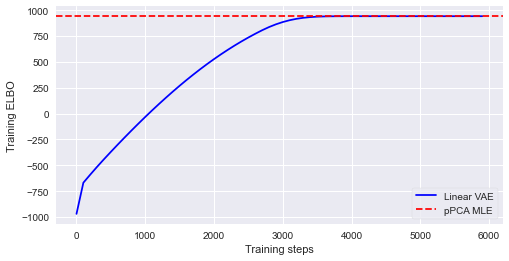

In [11]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(100*np.arange(len(elbos)), elbos, color='blue', label='Linear VAE')
ax.axhline(avg_log_p_mle, ls='--', color='red', label='pPCA MLE')
ax.set_xlabel('Training steps')
ax.set_ylabel('Training ELBO')
plt.legend(frameon=True)

In [12]:
W_vae, log_sigma_sq = sess.run([vae.dec_weight, vae.log_sigma_sq])
W_vae = W_vae.T
sigma_sq_vae = np.exp(log_sigma_sq)

Avg. VAE Likelihood: 941.4069714522963
Avg. Maximum Likelihood: 941.4504863864968


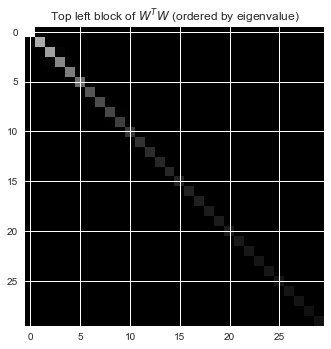

In [13]:
avg_log_p_vae = log_p_x_true(W_vae, sigma_sq_vae, DATA_SIZE, covariance)/DATA_SIZE

# Reordering rows/columns by eigenvalues for visualization
diag = np.diag(W_vae.T.dot(W_vae))
sort_idx = np.argsort(-diag)
P = np.zeros((W_vae.shape[1], W_vae.shape[1]))
for i,j in enumerate(sort_idx):
  P[i][j] = 1
ordered_WTW = P.dot(W_vae.T.dot(W_vae)).dot(P.T)

plt.figure()
plt.imshow(ordered_WTW[:30,:30], cmap='gray', vmin=0.0)
plt.title(r'Top left block of $W^T W$ (ordered by eigenvalue)')
print("Avg. VAE Likelihood: {}".format(avg_log_p_vae))
print("Avg. Maximum Likelihood: {}".format(avg_log_p_mle))